# Linear Kalman Filter for LIDAR data

This notebook shows a simple linear Kalman filter that processes LIDAR data. The data are from Udacity's Self-driving Car enineering class.  While the final project will be writeen in C++, this notebook uses Python to better understand the steps involved.  

## Read in the data.  The data contain both RADAR and LIDAR records so the RADAR are discarded here.

In [13]:
import numpy as np
from matplotlib import pyplot as plt

fname = './obj_pose-laser-radar-synthetic-input.txt'
LIDAR = []
RADAR = []
data = open(fname, "r")

for line in data:
   LIDAR.append(line.split()) if line[0] == 'L' else RADAR.append(line.split())

LIDAR = np.squeeze(np.array([LIDAR]))

lidar_x = LIDAR[:,1].astype(float).tolist()
lidar_y = LIDAR[:,2].astype(float).tolist()
lidar_ts = LIDAR[:,3].astype(int).tolist()
lidar_truth_x = LIDAR[:,4].astype(float).tolist()
lidar_truth_y = LIDAR[:,5].astype(float).tolist()
lidar_truth_xdot = LIDAR[:,6].astype(float).tolist()
lidar_truth_ydot = LIDAR[:,7].astype(float).tolist()

print(len(lidar_x), len(lidar_y), len(lidar_truth_x), len(lidar_truth_y))

250 250 250 250


In [14]:

##step 1/7
# The first step is to initialize the process covariance matrix.  The off daigonals
# can be set to zero.  The inital process covariance matrix is then updated on each
# iteration.

def initial_process_cov_matrix():
    global P
        
    #initial process covariance matrix
    ##do this once
    P = np.array([[1,0,0,0], [0,1,0,0], [0,0,1000,0],[0,0,0,1000]])
 
    ##however, you can usually eliminate the off diagonals
    P[0,1] = 0
    P[1,0] = 0
    if verbose: print("Initial Process Covariance Matrix:", P)
        
# The start of each iterators begins with a prediction step where previous 
# position, velocity (and acceleration [not used here]) are used to estimate
# the next state independent of measurements.

# The prediction step has two parts, 1) update_prediction and 2) update predicted
# process covariance matrix
        
##step 2/7; 
def update_prediction():
    global x,u,A,B
    #print("x before update:", x)
    x = np.dot(A,x) + np.dot(B,u)

    if verbose: print("x after update: ", x)
        
#step 3/7
def update_predicted_process_cov_matrix():
    global A, P, Q
    #update the Process Covariance Matrix
    #Q = 0.  ##reflects the error in calculating process cov matrix
    P = np.dot(np.dot(A, P), A.T) + Q
    #P[0,1] = 0
    #P[1,0] = 0
    if verbose: print("Predicted Process Covariance Matrix: ", P)


In [15]:
#step 4/7 calculate the kalman gain.  The Kalmna gain matrix detemines how
# much of the measurement and how much of the prediction to use in updating 
# the current state. 

def lidar_calculate_Kalman_gain():
    global R_lidar, P, H, K
    
    S = R_lidar + np.dot(H, np.dot(P, H.T))
    K = np.dot(np.dot(P, H.T), np.linalg.inv(S))
  
    if verbose:
        print("LIDAR S:", S)
        print("LIDAR: Kalman Gain Matrix: ", K)    


#step 5/7 import a measurment
# This step is not neccessary in this example; however, it is possible to 
# model measurement noise here.  
def lidar_import_new_observation(m):
    global z
    #Step 5/7
    ##import the new observation
    #Observed state Yk = CYkm + Zk
    C = np.eye(2)
    measurement = np.array(m)
    z = np.dot(C, measurement)
    
    if verbose: print("LIDAR: observed: ", z)

#step 6/7 update the current state
# Now that we have the updated prediction, Kalman gain and measurement, update
# the state.  This becomes the current state for the next iteration.
def lidar_update_current_state():
    global z, H, x
    #step 6/7
 
    Y = z - np.dot(H,x)
    x = x + np.dot(K, Y)
    
    if verbose:
        print("px:, py: vx: vy:", px, py, vx, vy)
        print("LIDAR: adjusted x:", x)
        print("LIDAR: Y: ", Y)
        
#step 7/7 update the process covariance matrix
# Use the Kalman gain to update the process covariance amtrix.  This updated
# matrix will be used at the current process covariance matrix for the next step.
def lidar_update_process_cov_matrix():
    global K, H, R_lidar, P

    I = np.eye(n)
    P = np.dot(np.dot(I - np.dot(K, H), P), 
                (I - np.dot(K, H)).T) + np.dot(np.dot(K, R_lidar), K.T)   

    if verbose: print("LIDAR: Updated Process Covariance Matrix: ", P)
        

In [16]:
##The A (aka F) matrix is the process noise covariance matrix
    
def update_A_matrix(dt):
    return np.array([[1,0,dt,0], [0,1, 0, dt], [0, 0, 1, 0], [0, 0, 0, 1]])

def update_Q_matrix(dt, noise_ax, noise_ay):
    return np.array([[np.power(dt,4)/4*noise_ax, 0, np.power(dt,3)/2*noise_ax, 0],
         [0, np.power(dt,4)/4*noise_ay, 0, np.power(dt,3)/2*noise_ay],
         [np.power(dt,3)/2*noise_ax, 0, np.power(dt,2)*noise_ax, 0],
         [0, np.power(dt,3)/2*noise_ay, 0, np.power(dt,2)*noise_ay]])

## Main program to run 

In [17]:
import numpy as np
from matplotlib import pyplot as plt


verbose = False

# this is the initial dt.  This value is updated on each iteration; however, in 
# this case it is always .1 second.
dt = .1

# R contains observation errors.  There are usually set once based on the sensor specs
# In some applications R may vary with iteratation or other factors (i.e., distance, speed)
R_lidar = np.array([[0.0225, 0], [0, 0.0225]])
 
    
H = np.array([[1, 0, 0, 0],[0,1, 0, 0]])

noise_ax, noise_ay = 5,5


A = update_A_matrix(dt)

B = np.zeros([4])
u = 0 #2 m/s**2

n = A.shape[1]
noise_ax, noise_ay = 5, 5

Q = update_Q_matrix(dt, noise_ax, noise_ay)
print("Q: ", Q)

current_timestamp = lidar_ts.pop(0)

x = np.array([lidar_truth_x.pop(0), lidar_truth_y.pop(0), 0, 0]) 
print("LIDAR initial timestamp: ", current_timestamp)
print("LIDAR initial x: ", x)
                                 
##initialize prediction
x_predict, y_predict = [], []
x_filtered, y_filtered, xdot_filtered, ydot_filtered = [], [], [], []
x_truth, y_truth = [], []
x_measured, y_measured = [], []

##since the first timestamp and ground truth are used for initializaton,
##pop the other values

lidar_x.pop(0), lidar_y.pop(0)
#lidar_truth_x.pop(0), lidar_truth_y.pop(0)
lidar_truth_xdot.pop(0), lidar_truth_ydot.pop(0)

print(len(lidar_x), len(lidar_y), len(lidar_truth_x), len(lidar_truth_y))

initial_process_cov_matrix()
print("initial timestamp: ", current_timestamp)
n_observations = len(lidar_x)

for obs in range(n_observations):
  #print("obs", obs)
  x_in, y_in = lidar_x[obs], lidar_y[obs]
  ts = lidar_ts[obs]
  x_truth, y_truth = lidar_truth_x[obs], lidar_truth_y[obs]
  xdot_truth, ydot_truth = lidar_truth_xdot[obs], lidar_truth_ydot[obs] 
    
  previous_timestamp = current_timestamp

  #update the A and Q matrices
 
  current_timestamp = ts
  dt =  (current_timestamp - previous_timestamp)/1000000.

  if verbose: print("dt: ", dt, current_timestamp, previous_timestamp)
  A = update_A_matrix(dt)
  Q = update_Q_matrix(dt, noise_ax, noise_ay) 
  
  update_prediction()
 
  update_predicted_process_cov_matrix()
      
  x_predict.append(x[0])
  y_predict.append(x[1])
                
  #compute the Kalman gain
  lidar_calculate_Kalman_gain()  #now in polar

  lidar_import_new_observation ([x_in, y_in])
  lidar_update_current_state()
        
  lidar_update_process_cov_matrix()
    
  #x = np.array([cartesian[0], cartesian[1], cartesian[2], cartesian[3]])  
  x_filtered.append(x[0])
  y_filtered.append(x[1])
  xdot_filtered.append(x[2])
  ydot_filtered.append(x[3])
    

Q:  [[0.000125 0.       0.0025   0.      ]
 [0.       0.000125 0.       0.0025  ]
 [0.0025   0.       0.05     0.      ]
 [0.       0.0025   0.       0.05    ]]
LIDAR initial timestamp:  1477010443000000
LIDAR initial x:  [0.6 0.6 0.  0. ]
249 249 249 249
initial timestamp:  1477010443000000


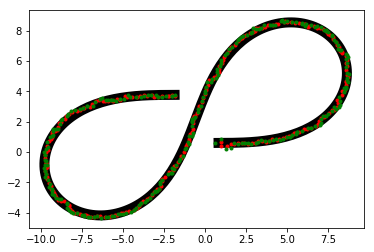

In [20]:
#plt.plot(x_predict, y_predict)
#plt.show()
plt.plot(lidar_truth_x, lidar_truth_y,'k', linewidth=10)
#plt.plot(x_measured, y_measured, 'r.')
plt.plot(x_filtered, y_filtered, 'r.')
plt.plot(x_predict, y_predict, 'g.')
plt.show()

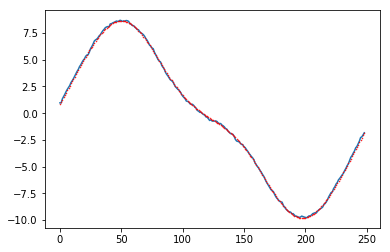

In [51]:
plt.plot(np.array(x_filtered))
plt.plot(np.array(lidar_truth_x),'r.', markersize=1)

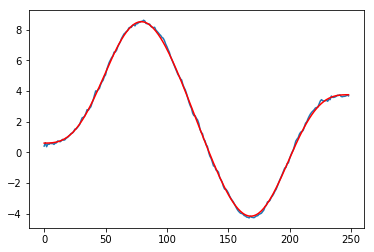

In [52]:
plt.plot(np.array(y_filtered))
plt.plot(np.array(lidar_truth_y),'r')               

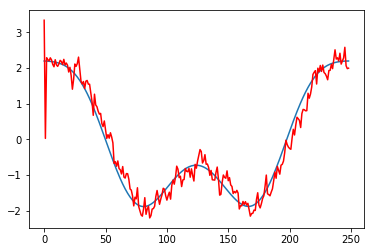

In [53]:
plt.plot(lidar_truth_xdot)
plt.plot(xdot_filtered,'r')
#plt.plot(ydot_truth,'r')
plt.show()

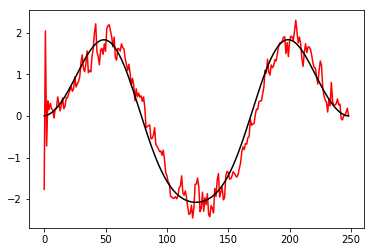

In [54]:

plt.plot(ydot_filtered,'r')
plt.plot(lidar_truth_ydot,'k')
plt.show()

In [55]:
def calculate_RMSE(predicted_values,truth_values):
    residuals = np.array(predicted_values) - np.array(truth_values)
    sum_residuals = np.sum(residuals*residuals)
    mean_error = sum_residuals/len(residuals)
    return np.sqrt(mean_error)

In [44]:
x_rmse = calculate_RMSE(x_filtered, lidar_truth_x)
y_rmse = calculate_RMSE(y_filtered, lidar_truth_y)

print("x_rmse, y_rmse: ", x_rmse, y_rmse)

xdot_rmse = calculate_RMSE(xdot_filtered, lidar_truth_xdot)
ydot_rmse = calculate_RMSE(ydot_filtered, lidar_truth_ydot)

print("xdot_rmse, ydot_rmse: ", xdot_rmse, ydot_rmse)

x_rmse, y_rmse:  0.08465380751280971 0.09479801945786345
xdot_rmse, ydot_rmse:  0.3001629057873732 0.3226862321772166
